In [15]:
import cv2
import numpy as np
from tqdm import tqdm

def adaptive_background_subtraction(frame_sequence, method='MOG2', verbose=False):
    """
    Use background subtraction to identify changing regions without true background
    """
    if verbose:
        print(f"Using background subtraction method: {method}")

    if method == 'MOG2':
        backSub = cv2.createBackgroundSubtractorMOG2(detectShadows=True)
    elif method == 'KNN':
        backSub = cv2.createBackgroundSubtractorKNN(detectShadows=True)
    
    motion_masks = []
    
    for frame in frame_sequence:
        # Apply background subtraction
        fg_mask = backSub.apply(frame)
        
        # Noise reduction
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, kernel)
        
        motion_masks.append(fg_mask)
    
    return motion_masks


def temporal_leak_filtering(motion_masks, k1=10, n1=1, tau_iou=0.3, k2=3, verbose=False):
    """
    Apply temporal filtering to distinguish leaks from normal motion
    
    Args:
        motion_masks: Sequence of binary masks from background subtraction
        k1: Number of past frames to check for persistence
        n1: Minimum number of frames that must contain similar regions
        tau_iou: IoU threshold for region similarity
        k2: Number of frames to look back for vanished leaks
    """
    
    def get_connected_components(mask):
        """Extract connected components as potential leak regions"""
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)
        components = []
        
        for i in range(1, num_labels):  # Skip background label 0
            component_mask = (labels == i).astype(np.uint8) * 255
            x, y, w, h, area = stats[i]
            
            if area > 50:  # Filter small noise
                components.append({
                    'mask': component_mask,
                    'bbox': (x, y, w, h),
                    'centroid': centroids[i],
                    'area': area
                })
        
        return components
    
    def calculate_region_iou(comp1, comp2):
        """Calculate IoU between two component masks"""
        intersection = cv2.bitwise_and(comp1['mask'], comp2['mask'])
        union = cv2.bitwise_or(comp1['mask'], comp2['mask'])
        
        if np.sum(union) == 0:
            return 0
        
        return np.sum(intersection) / np.sum(union)
    
    persistent_leaks = []
    if verbose:
        print(f"Starting temporal leak filtering with k1={k1}, n1={n1}, tau_iou={tau_iou}, k2={k2}")
        iterator = tqdm(enumerate(motion_masks), total=len(motion_masks), desc="Processing frames")
    else:
        iterator = iter(enumerate(motion_masks))

    for frame_idx, current_mask in iterator:
        current_components = get_connected_components(current_mask)
        frame_leaks = np.zeros_like(current_mask)
        
        for component in current_components:
            # Check persistence in past k1 frames
            matches_found = 0
            
            start_idx = max(0, frame_idx - k1)
            for past_idx in range(start_idx, frame_idx):
                past_components = get_connected_components(motion_masks[past_idx])
                
                for past_comp in past_components:
                    if calculate_region_iou(component, past_comp) > tau_iou:
                        matches_found += 1
                        break
            
            # If component is persistent enough, consider it a leak
            if matches_found >= n1:
                frame_leaks = cv2.bitwise_or(frame_leaks, component['mask'])
        
        # Handle vanished leaks (look back k2 frames)
        if np.sum(frame_leaks) == 0 and frame_idx >= k2:
            for back_idx in range(1, k2 + 1):
                if frame_idx - back_idx >= 0:
                    prev_components = get_connected_components(motion_masks[frame_idx - back_idx])
                    # Add logic to restore persistent leaks that might have been missed
        
        persistent_leaks.append(frame_leaks)
    
    return persistent_leaks


def optical_flow_leak_detection(frame_sequence):
    """
    Use optical flow to detect regions with unusual motion patterns
    """
    leak_candidates = []
    
    for i in range(len(frame_sequence) - 1):
        gray1 = cv2.cvtColor(frame_sequence[i], cv2.COLOR_BGR2GRAY)
        gray2 = cv2.cvtColor(frame_sequence[i + 1], cv2.COLOR_BGR2GRAY)
        
        # Calculate dense optical flow
        flow = cv2.calcOpticalFlowPyrLK(gray1, gray2, None, None)
        
        # Detect regions with minimal flow (static background leaks)
        flow_magnitude = np.sqrt(flow[..., 0]**2 + flow[..., 1]**2)
        static_regions = flow_magnitude < 2.0  # Threshold for "static"
        
        # Convert to uint8 mask
        static_mask = static_regions.astype(np.uint8) * 255
        leak_candidates.append(static_mask)
    
    return leak_candidates


def edge_based_leak_detection(frame_sequence, virtual_background_estimate):
    """
    Detect leaks based on edge inconsistencies
    """
    leak_masks = []
    
    for frame in frame_sequence:
        # Calculate edges for both frame and estimated virtual background
        frame_edges = cv2.Canny(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY), 50, 150)
        bg_edges = cv2.Canny(cv2.cvtColor(virtual_background_estimate, cv2.COLOR_BGR2GRAY), 50, 150)
        
        # Find edge differences
        edge_diff = cv2.absdiff(frame_edges, bg_edges)
        
        # Apply morphological operations
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
        edge_leak_mask = cv2.morphologyEx(edge_diff, cv2.MORPH_CLOSE, kernel)
        
        leak_masks.append(edge_leak_mask)
    
    return leak_masks


def standalone_leak_detection_pipeline(frame_sequence, confidence_threshold=0.7, verbose=False):
    """
    Complete pipeline for leak detection without true background
    """
    
    # Step 1: Background subtraction for motion detection
    if verbose: 
        print("Step 1: Adaptive background subtraction")
    motion_masks = adaptive_background_subtraction(frame_sequence, method='MOG2')
    
    # Step 2: Temporal filtering for persistent regions
    if verbose:
        print("Step 2: Temporal leak filtering")
    persistent_masks = temporal_leak_filtering(motion_masks, verbose=verbose)
    
    # Step 3: Optical flow analysis for static anomalies
    if verbose:
        print("Step 3: Optical flow leak detection")
    optical_flow_masks = optical_flow_leak_detection(frame_sequence)
    
    # Step 4: Estimate virtual background from mode of pixel values
    if verbose:
        print("Step 4: Estimating virtual background mode")
    virtual_bg_estimate = estimate_virtual_background_mode(frame_sequence)
    
    # Step 5: Edge-based detection
    if verbose:
        print("Step 5: Edge-based leak detection")
    edge_masks = edge_based_leak_detection(frame_sequence, virtual_bg_estimate)
    
    if verbose:
        print("Step 6: Combining all methods with confidence scoring")
    # Step 6: Combine all methods with confidence scoring
    final_masks = []
    
    for i in range(len(frame_sequence)):
        # Normalize all masks to 0-1
        motion_score = persistent_masks[i] / 255.0 if i < len(persistent_masks) else np.zeros_like(motion_masks[0])
        flow_score = optical_flow_masks[i] / 255.0 if i < len(optical_flow_masks) else np.zeros_like(motion_masks[0])
        edge_score = edge_masks[i] / 255.0 if i < len(edge_masks) else np.zeros_like(motion_masks[0])
        
        # Weighted combination
        combined_confidence = (0.5 * motion_score + 0.3 * flow_score + 0.2 * edge_score)
        
        # Apply threshold
        final_mask = (combined_confidence > confidence_threshold).astype(np.uint8) * 255
        final_masks.append(final_mask)
    
    return final_masks

from truesight.features import mode_feature
def estimate_virtual_background_mode(frame_sequence):
    """Estimate virtual background by finding modal color of each pixel"""
    # h, w, c = frame_sequence[0].shape
    # virtual_bg = np.zeros((h, w, c), dtype=np.uint8)
    
    # for i in range(h):
    #     for j in range(w):
    #         pixel_values = [frame[i, j] for frame in frame_sequence]
    #         # Find most common color (mode) - simplified approach
    #         virtual_bg[i, j] = np.median(pixel_values, axis=0)
    
    # return virtual_bg
    return mode_feature(frame_sequence)


(PosixPath('data/public/videos/2_i_setup_bridge_mp.mp4'), PosixPath('data/public/masks/2_i_setup_mp.png'), PosixPath('data/public/backgrounds/setup.png'))


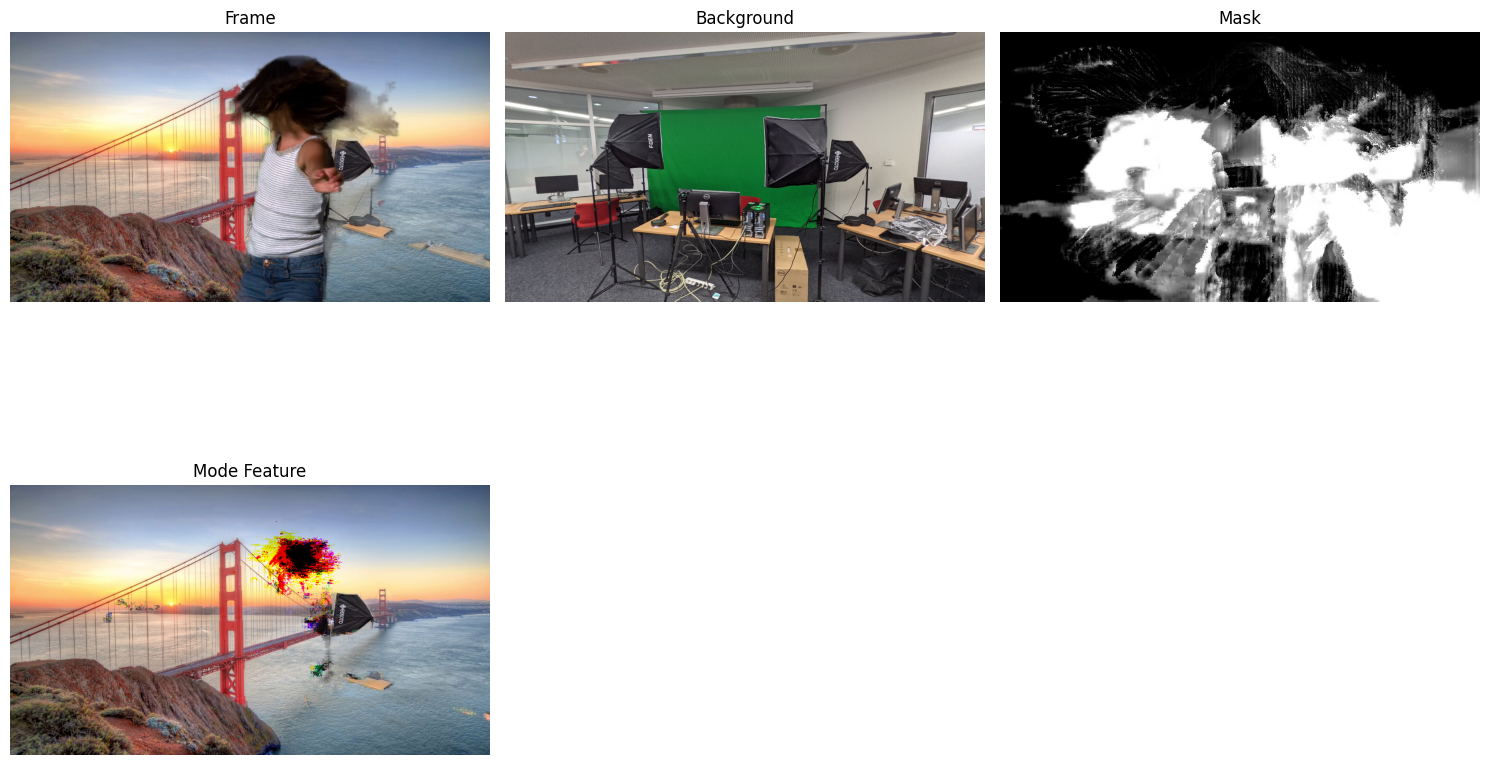

In [16]:
from json import load
from scipy.ndimage import median_filter
from matplotlib.pylab import f
import matplotlib.pyplot as plt
from truesight.masks import create_continuous_similarity_mask
from truesight.util import load_video, load_background, load_mask, load_triplets, show_image, show_images
from truesight.features import mode_feature
import numpy as np
# import logarithm


triplets = load_triplets("data/public/backgrounds", "data/public/videos","data/public/masks")
sample = triplets[30]
print(sample)
video = np.array(load_video(sample[0]))
background = load_background(sample[2])
mask = load_mask(sample[1])
mask_f = mask.astype(float) / 255.0
frame_idx = 250
frame = video[frame_idx]

video_mode = mode_feature(video).numpy()

show_images(
    [frame, background, mask, video_mode],
    titles=["Frame", "Background", "Mask", "Mode Feature"],
)

In [17]:
output = standalone_leak_detection_pipeline(video, confidence_threshold=0.7, verbose=True)

Step 1: Adaptive background subtraction
Step 2: Temporal leak filtering
Starting temporal leak filtering with k1=10, n1=1, tau_iou=0.3, k2=3


Processing frames:   4%|▍         | 15/360 [10:10<3:54:04, 40.71s/it]


KeyboardInterrupt: 